In [77]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn; seaborn.set()

## ETFs data

In [63]:
etfs = ['VAW', 'VCR', 'VDC', 'VDE', 'VFH', 'VGT', 'VHT', 'VIS', 'VNQ', 'VOX', 'VPU']
data = pd.DataFrame()
for etf in etfs:
    data[etf] = pd.read_csv(etf+'.csv', index_col = 'Date')['Adj Close']

bwdRet = (data/data.shift(1)-1).dropna()
bwdRet.index =pd.to_datetime(bwdRet.reset_index()['Date'])
bwdRet.head()

,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,
2004-09-30,0.014098,0.012552,0.010714,0.009005,0.002185,0.002403,-0.014966,0.008333,0.008025,0.001621,0.002993
2004-10-01,0.007499,0.012810,0.010208,0.012892,0.012887,0.032119,0.010551,0.000000,0.018507,0.000000,0.008577
2004-10-04,0.003268,0.007548,0.001943,0.000979,0.004110,0.014863,0.006891,0.018544,0.004299,0.000000,0.001664
2004-10-05,-0.002533,-0.006479,-0.005043,0.009194,-0.005848,-0.006407,-0.006636,-0.004552,-0.000195,0.000000,0.004799
2004-10-06,0.013969,0.007336,0.002339,0.019190,0.004705,0.010134,-0.000626,0.005368,0.004670,0.034392,0.002021


In [26]:
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd,CLA
from HRP import correlDist,getIVP,getQuasiDiag,getRecBipart

# def generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F):
#     # Time series of correlated variables
#     #1) generate random uncorrelated data
#     x=np.random.normal(mu0,sigma0,size=(nObs,size0))
#     #2) create correlation between the variables
#     cols=[random.randint(0,size0 - 1) for i in range(size1)]
#     y=x[:,cols]+np.random.normal(0,sigma0*sigma1F,size=(nObs,len(cols)))
#     x=np.append(x,y,axis=1)
#     #3) add common random shock
#     point=np.random.randint(sLength,nObs-1,size=2)
#     x[np.ix_(point,[cols[0],size0])]=np.array([[-.5,-.5],[2,2]])
#     #4) add specific random shock
#     point=np.random.randint(sLength,nObs-1,size=2)
#     x[point,cols[-1]]=np.array([-.5,2])
#     return x,cols
#———————————————————————————————————————
def getHRP(cov,corr):
    # Construct a hierarchical portfolio
    corr,cov=pd.DataFrame(corr),pd.DataFrame(cov)
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    hrp=getRecBipart(cov,sortIx)
    return hrp.sort_index()
#———————————————————————————————————————
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean=np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB=np.zeros(mean.shape)
    uB=np.ones(mean.shape)
    cla=CLA.CLA(mean,cov,lB,uB)
    cla.solve()
    #print(cla.mean)
    return cla.w[-1].flatten()
#———————————————————————————————————————
# def hrpMC(numIters=10,nObs=520,size0=5,size1=5,mu0=0,sigma0=1e-2, \
#     sigma1F=.25,sLength=260,rebal=22):
#     # Monte Carlo experiment on HRP
#     methods=[getIVP,getHRP,getCLA]
#     stats,numIter={i.__name__:pd.Series() for i in methods},0
#     pointers=range(sLength,nObs,rebal)
#     while numIter<numIters:
#         print (numIter)
#         #1) Prepare data for one experiment
#         x,cols=generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F)
#         r={i.__name__:pd.Series() for i in methods}
#         #2) Compute portfolios in-sample
#         for pointer in pointers:
#             x_=x[pointer-sLength:pointer]
#             cov_,corr_=np.cov(x_,rowvar=0),np.corrcoef(x_,rowvar=0)
#             #3) Compute performance out-of-sample
#             x_=x[pointer:pointer+rebal]
#             for func in methods:
#                 w_=func(cov=cov_,corr=corr_) # callback
#                 r_=pd.Series(np.dot(x_,w_))
#                 r[func.__name__]=r[func.__name__].append(r_)
#         #4) Evaluate and store results
#         for func in methods:
#             r_=r[func.__name__].reset_index(drop=True)
#             p_=(1+r_).cumprod()
#             stats[func.__name__].loc[numIter]=p_.iloc[-1]-1
#         numIter+=1
#     #5) Report results
#     stats=pd.DataFrame.from_dict(stats,orient='columns')
#     stats.to_csv('stats.csv')
#     df0,df1=stats.std(),stats.var()
#     print(pd.concat([df0,df1,df1/df1['getHRP']-1],axis=1))

## Every month, look back 3 months to caculate the new allocation

In [107]:
def rolling_portfolio(func):
    weight = pd.DataFrame(columns =etfs) 
    for i in tqdm(range(60,len(bwdRet),20)): 
        #  Compute one covariance matrix every month, looking back three months at each calculation.        
        date = bwdRet.index[i]   # today
        cov = np.array(bwdRet.iloc[i-60:i].cov())
        corr = np.array(bwdRet.iloc[i-60:i].cov())
        
        # use fancy methods
        weight.loc[date] = np.array(func(cov = cov, corr = corr)) # new weight as of yesterday's close
          
    return weight

start = pd.datetime.now()
wHRP = rolling_portfolio(getHRP)
end = pd.datetime.now()
print('HRP time:',end - start)
start = end
wCLA = rolling_portfolio(getCLA)
end = pd.datetime.now()
print('CLA time:',end - start)
start = end
wIVP = rolling_portfolio(getIVP)
end = pd.datetime.now()
print('IVP time:',end - start)

 10%|█         | 18/176 [00:00<00:00, 179.34it/s]

HRP time: 0:00:08.402083


 31%|███▏      | 55/176 [00:00<00:00, 545.32it/s]

CLA time: 0:00:00.897404


100%|██████████| 176/176 [00:00<00:00, 532.99it/s]

IVP time: 0:00:00.334605


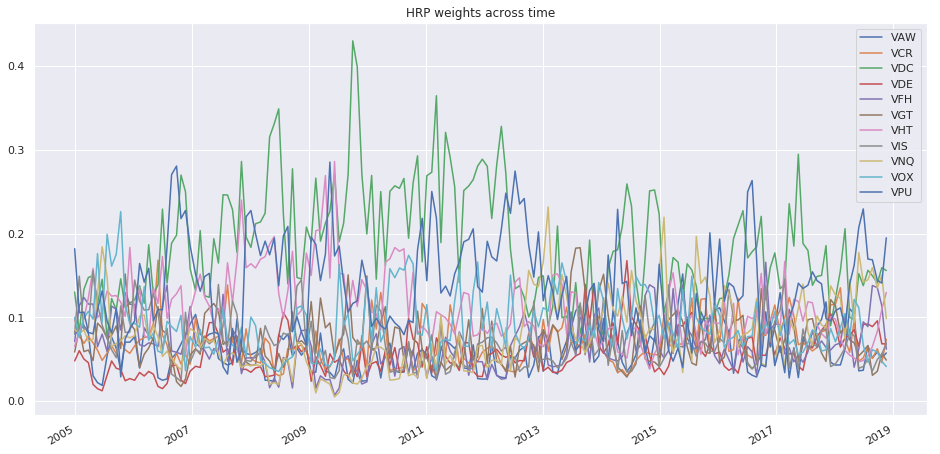

In [122]:
wHRP.plot(figsize = (16,8),title = 'HRP weights across time');

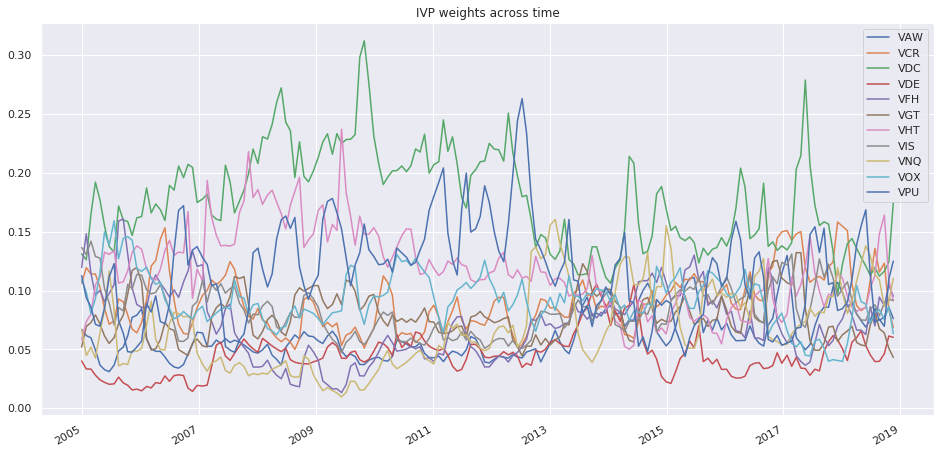

In [121]:
wIVP.plot(figsize = (16,8),title ='IVP weights across time');

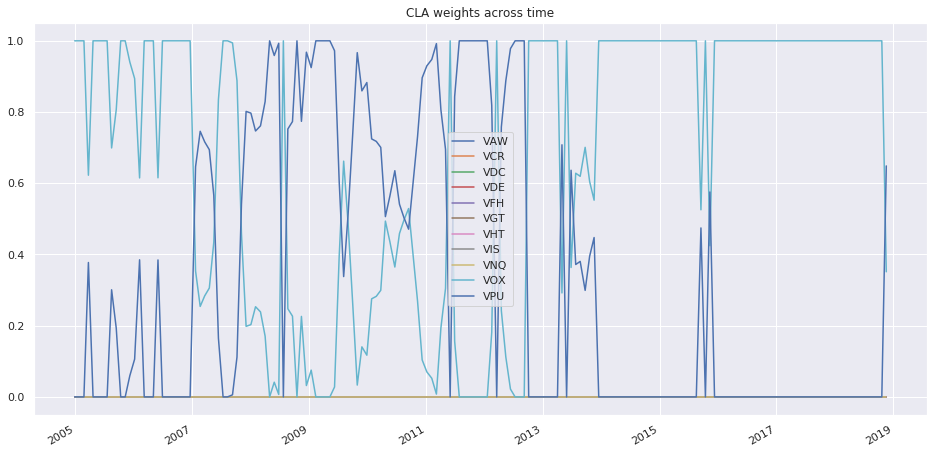

In [120]:
wCLA.plot(figsize = (16,8),title = 'CLA weights across time');

## Backtest
- with a transaction cost of 5 basis point per rebalance.

In [206]:
import matplotlib.pyplot as plt

# given weights over time, return the backtest result
def backtest(wHRP, ax):
    w = pd.DataFrame(columns = etfs, index = bwdRet.index)
    w.loc[wHRP.index] = wHRP
    w = w.fillna(method = 'ffill')
    daily_ret = (w*bwdRet).sum(axis = 1)
    # including transaction cost, 5 bps per rebalance
    daily_ret -= abs(w-w.shift(1)).sum(axis =1)*0.0005
    cum_ret = daily_ret.cumsum()
    
    # Metrics
    anl_ret = daily_ret.mean()*252
    SR = anl_ret/daily_ret.std()/np.sqrt(252)
    maxdd = np.max(np.maximum.accumulate(cum_ret) - cum_ret)
    to = (abs(w-w.shift(1))).sum(axis = 1).mean()
    
    # plot
    
    #fig = plt.figure(figsize =(12,5))
    #ax = plt.subplot()
    ax.plot(cum_ret)

    text = 'Sharpe: %.2f\nAnlRet: %.2f%%\nMaxDD: %.2f%%\nTurnOver(dail: %.2f%%' % (SR,anl_ret*100,maxdd*100, to*100)
    plt.text(0, .75, text, transform=ax.transAxes, bbox = {'facecolor':'none','alpha':0.25,'edgecolor':'blue'})
    
    return 

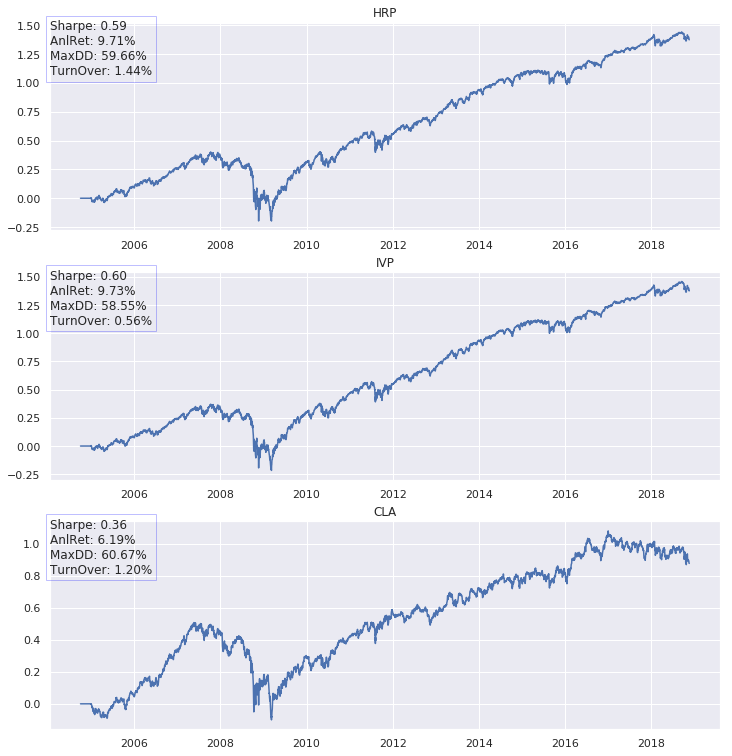

In [217]:
fig = plt.figure(figsize = (12,13))
ax = plt.subplot(311)
backtest(wHRP, ax)
plt.title('HRP')
ax = fig.add_subplot(312)
backtest(wIVP, ax)
plt.title('IVP')
ax = fig.add_subplot(313)
backtest(wCLA, ax)
plt.title('CLA')
plt.show()